# Housing Price:

### Predict sales prices and practice feature engineering, RFs, and gradient boosting. 

**Source: This project is inspired from a competition in Kaggle. For more details see the [competition page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).   
The purpose is to predict the final price of each house with 79 explanatory variables describing (almost) every aspect of residential homes in Ames, lowa**


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
sns.set(style = "whitegrid", color_codes = True)
sns.set(font_scale = 1)
#from astropy.table import Table, Column
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score, KFold
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import clone
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import log_loss
import pickle
import random
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

### Load data
We will use pandas for importing data. All datas would be found in [Data Housing Price](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [30]:
#Import training data
train = pd.read_csv("data/train.csv")
#Import test data
test = pd.read_csv("data/test.csv")

### Take a look on data overall (infos, shape, missing data...)
This step allows us to know shape of whole data, how many columns having missing data, which columns are catergory datas, numeric datas.

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [15]:
# missing data
train.isnull().mean().sort_values(ascending = False)

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
FireplaceQu      0.472603
LotFrontage      0.177397
GarageCond       0.055479
GarageType       0.055479
GarageYrBlt      0.055479
GarageFinish     0.055479
GarageQual       0.055479
BsmtExposure     0.026027
BsmtFinType2     0.026027
BsmtFinType1     0.025342
BsmtCond         0.025342
BsmtQual         0.025342
MasVnrArea       0.005479
MasVnrType       0.005479
Electrical       0.000685
Utilities        0.000000
YearRemodAdd     0.000000
MSSubClass       0.000000
Foundation       0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior2nd      0.000000
Exterior1st      0.000000
RoofMatl         0.000000
RoofStyle        0.000000
YearBuilt        0.000000
                   ...   
GarageArea       0.000000
PavedDrive       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
3SsnPorch        0.000000
BsmtUnfSF        0.000000
ScreenPorch      0.000000
PoolArea    

Comment:   
1.Shape: Size of training data is 1460 x 81. It means we have 1460 data samples, 81 variables (features) in training data. 
But in test data, we have only 80 features because of lack of the column price that we have to use our model results to predict.

2.In training data, we have 43 object features (category data, non-numeric data), 35 integer features, 3 float features. 

3.Missing Data: we have many columns which have missing data  
 
+> Columns **'PoolQC', 'Fence', 'MiscFeature','Alley', 'FireplaceQu'** whose data are almost missing => we can drop them out because they don't have big impact on final price of houses  
+> Some columns have the same number of missing data (Ex 'MasVnrType' vs 'MasVnrArea', 'BsmtQual' vs BsmtCond'...)
Maybe they are correlated to each other  
 


### Analyzing by visualizing Data
### Correlation in Data

In [16]:
#calculate number of categorical features and numerical features
categorical_features = train.select_dtypes(include=["object"]).columns
numerical_features = train.select_dtypes(exclude=["object"]).columns
train_cat = train[categorical_features]
train_num = train[numerical_features]
print("Numerical features :" + str(len(numerical_features)))
print("Categorical features :" + str(len(categorical_features)))

#Calculate correlation between variables and target
corr = train.corr()['SalePrice']
corr[np.argsort(corr,axis=0)[::-1]]


Numerical features :38
Categorical features :43


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


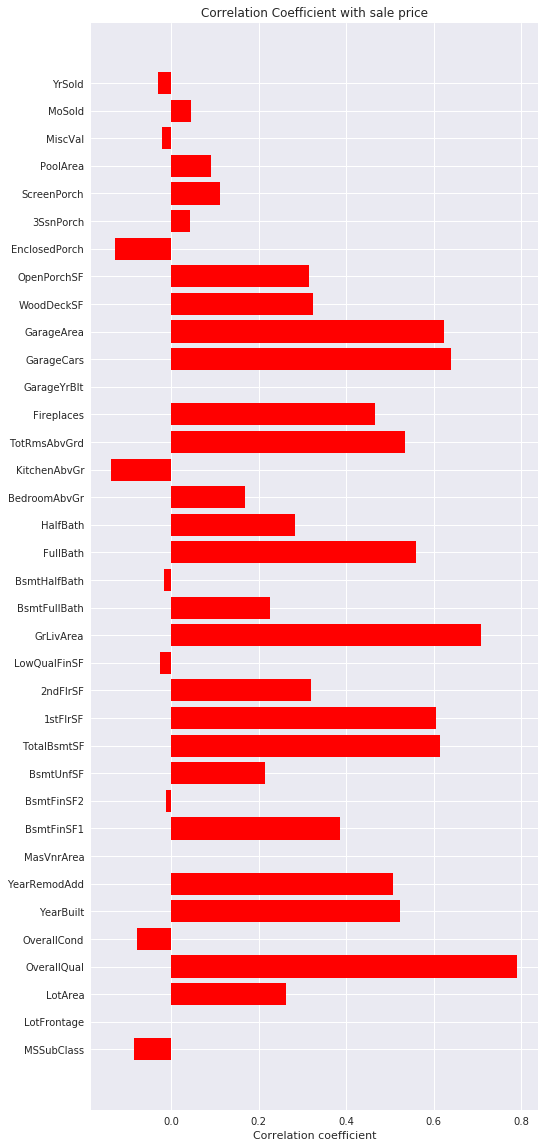

In [17]:
#graphique: plotting correlations with housing price
num_features = numerical_features[1:-1] #exclude 1st column Id et last column SalePrice
label = []
value = []
for col in num_features:
    label.append(col)
    value.append(np.corrcoef(train[col].values, train['SalePrice'].values)[0,1])
ind = np.arange(len(label))
width = 0.
fig, ax = plt.subplots(figsize =(8,20)) #create a frame
rects = ax.barh(ind, np.array(value), color = 'red')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(label, rotation = 'horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficient with sale price")

So we can see that all features: **OverallQual; GrLivArea; GarageCars; GarageArea; TotalBsmtSF; 1stFlrSF; FullBath; TotRmsAbvGrd; YearBuilt; YearRemodAdd** have a big correlation with target variable SalePrice (Correlation coeff > 0.5) => they may be become important features predicting price of house

### Heat map

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


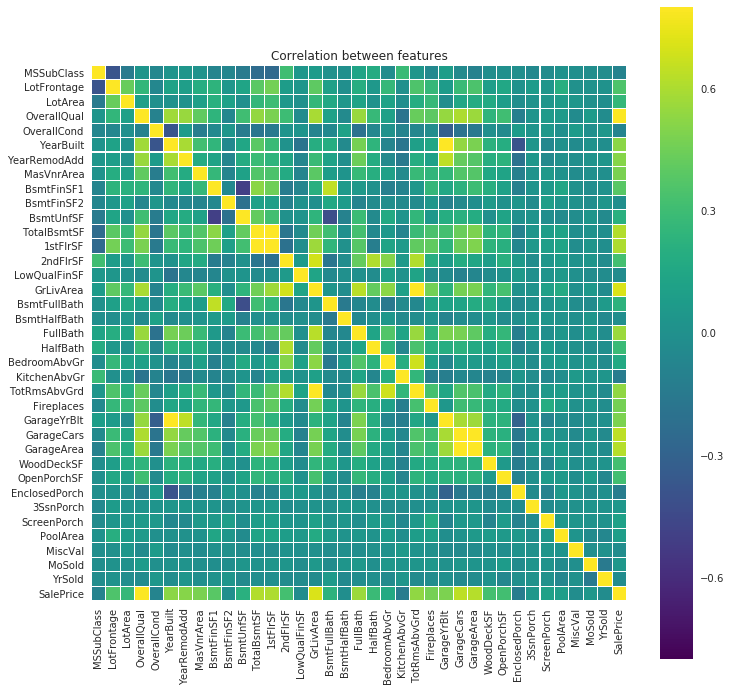

In [18]:
corrMatrix = train.select_dtypes(include = ['Float64','int64']).iloc[:,1:].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corrMatrix,vmax = .8, linewidths = 0.01, square = True, cmap = 'viridis', linecolor ='white')
plt.title('Correlation between features')

**Comment:**    
+> we confirm what we have said earlier about features which have a big correlation with Sale Price  
+> Some features have a correlation with each other  
(TotalBsmtSF vs 1stFlrSF)  
(GarageArea vs GarageCars)  
(GarageYrBlt vs YearBuilt)  
(TotRmsAbvGrd vs GrLivArea)  
(Garage... vs Garage..)  
The fact that we know which features are correlated with others can helps us fill missing value of some features from data of others


So we can drop out columns that have been correlated with others and keep columns which are correlated most with Sale Price

In [19]:
#correlations between features among each other
corre = train.corr()
attrs = corre.iloc[:-1,:-1] #all except target
threshold = 0.5
important_corrs =(attrs[abs(attrs)>threshold][attrs != 1.]).unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(list(set([(tuple(sorted(key)), important_corrs[key]) for key in important_corrs])), columns =['Attribute Pair','Correlations'])
unique_important_corrs = unique_important_corrs.ix[abs(unique_important_corrs['Correlations']).argsort()[::-1]]
print(unique_important_corrs)

                  Attribute Pair  Correlations
18      (GarageArea, GarageCars)      0.882475
21      (GarageYrBlt, YearBuilt)      0.825667
5      (GrLivArea, TotRmsAbvGrd)      0.825489
0        (1stFlrSF, TotalBsmtSF)      0.819530
20         (2ndFlrSF, GrLivArea)      0.687501
27  (BedroomAbvGr, TotRmsAbvGrd)      0.676620
19    (BsmtFinSF1, BsmtFullBath)      0.649212
26   (GarageYrBlt, YearRemodAdd)      0.642277
8          (FullBath, GrLivArea)      0.630012
25      (2ndFlrSF, TotRmsAbvGrd)      0.616423
23          (2ndFlrSF, HalfBath)      0.609707
24     (GarageCars, OverallQual)      0.600671
11      (GrLivArea, OverallQual)      0.593007
12     (YearBuilt, YearRemodAdd)      0.592855
3      (GarageCars, GarageYrBlt)      0.588920
10      (OverallQual, YearBuilt)      0.572323
9          (1stFlrSF, GrLivArea)      0.566024
2      (GarageArea, GarageYrBlt)      0.564567
6      (GarageArea, OverallQual)      0.562022
7       (FullBath, TotRmsAbvGrd)      0.554784
15   (Overall

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


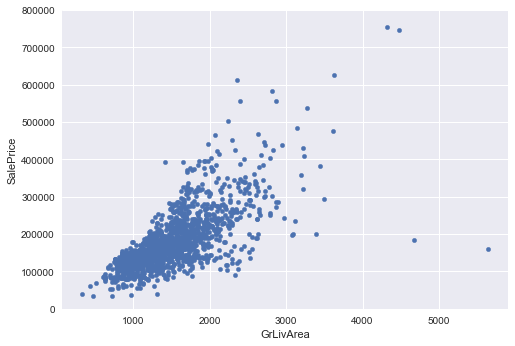

In [12]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data_GrLivArea = pd.concat([train['SalePrice'], train[var]], axis=1)
data_GrLivArea.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

SalePrice and GrLivArea have a linear realtionship. But we can see 2 points outliers in this graph with bigger values of GrLivArea => We should delete them.

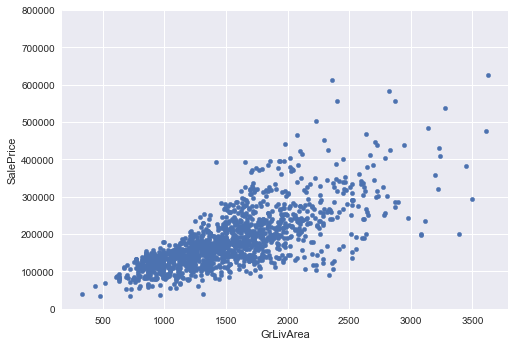

In [13]:
#deleting points
train = train.drop(train[train['GrLivArea'] > 4000].index)
#train['GrLivArea'] = train['GrLivArea'].fillna(train['GrLivArea'].mean())
data_GrLivArea = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data_GrLivArea.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

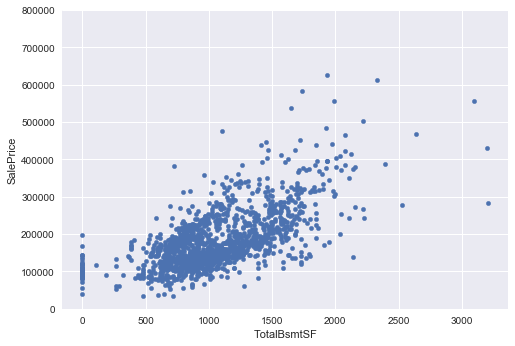

In [14]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### Pivotal Features

In [21]:
#Pivot between SalePrice and OverallQual
train[['OverallQual','SalePrice']].groupby(['OverallQual'],as_index= False).mean().sort_values(by='OverallQual', ascending = False)

,OverallQual,SalePrice
9,10,438588.388889
8,9,367513.023256
7,8,274735.535714
6,7,207716.423197
5,6,161603.034759
4,5,133523.347607
3,4,108420.655172
2,3,87473.750000
1,2,51770.333333
0,1,50150.000000


We can see that SalePrice is descending following order of OverallQual

In [22]:
#Pivot between SalePrice and GrLivArea
train[['GrLivArea','SalePrice']].groupby(['GrLivArea'],as_index= False).mean().sort_values(by='SalePrice', ascending = False)

,GrLivArea,SalePrice
857,4316,755000.000000
858,4476,745000.000000
856,3627,625000.000000
772,2364,611657.000000
836,2822,582933.000000
838,2868,556581.000000
780,2402,555000.000000
851,3279,538000.000000
744,2234,501837.000000
846,3140,485000.000000


We have 861 different values in this pivot. we can divide them into little group of values in order to see the impact of some intervall of groupe living area in sale price  

### Categorical features


In [17]:
print(train.select_dtypes(include = ['object']).columns.values)

['MSZoning' 'Street' 'LotShape' 'LandContour' 'Utilities' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2' 'BldgType'
 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC'
 'CentralAir' 'Electrical' 'KitchenQual' 'Functional' 'GarageType'
 'GarageFinish' 'PavedDrive' 'SaleType' 'SaleCondition']


**Housing Style, BldgType, Neighborhood**  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

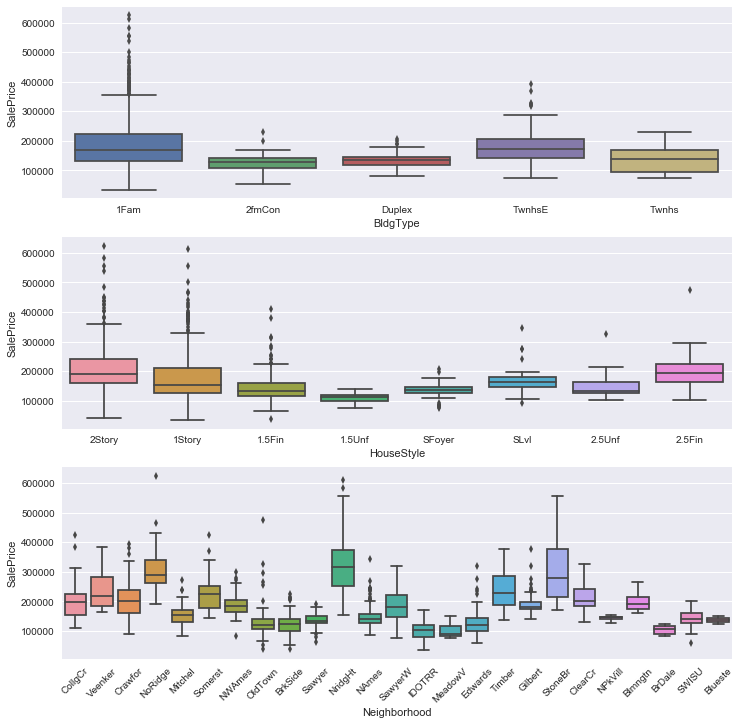

In [18]:
fig, ax = plt.subplots(3,1, figsize = (12,12))
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = train, ax = ax[0])
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data = train, ax = ax[1])
sns.boxplot(x='Neighborhood', y = 'SalePrice', data = train, ax = ax[2])
plt.xticks(rotation = 45)

### Analyzing Target

**Normality** - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.  

**Homoscedasticity** - Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.  

**Linearity**- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.  

**Absence of correlated errors** - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


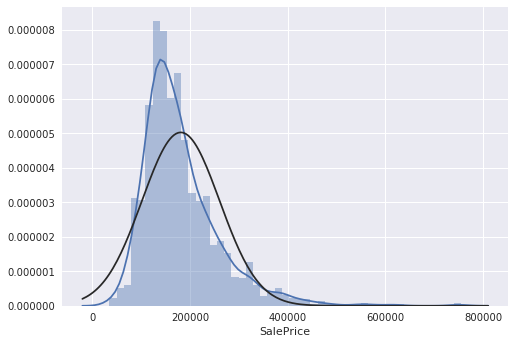

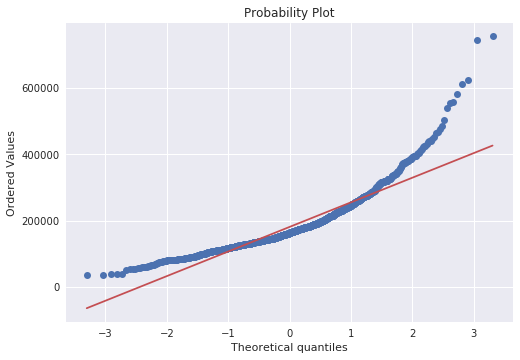

In [23]:
#histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

**Comments:**    
Target 'SalePrice' is not normal. It shows a positive Skewness.   
Note: In case of positive skewness, we would use log transformations to make it become normal.

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


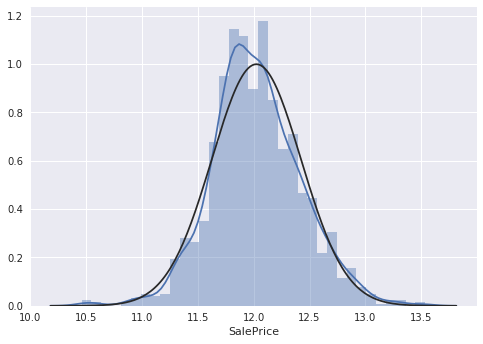

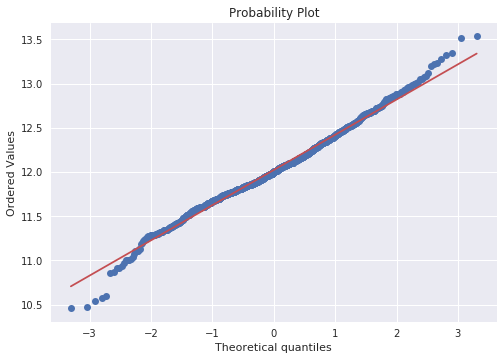

In [24]:
#applying log transformation
train['SalePrice'] = np.log1p(train['SalePrice'])

#transformed histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [28]:
#log transform skewed numeric features:
numeric_feats = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

X_train = train.ix[:,:-1]
X_test = test.iloc[:,:test.shape[0]]
y = train.SalePrice
print(X_train.head())

train[skewed_feats] = np.log1p(train[skewed_feats])
test[skewed_feats] = np.log1p(test[skewed_feats])

   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1          ...           SaleType_ConLI  \
0          2003       196.0         706          ...                        0   
1          1976         0.0         978          ...                        0   
2          2002       162.0         486          ...                        0   
3          1970         0.0         216          ...                        0   
4          2000       350.0         655          ...                        0   

   SaleType_ConLw  SaleType_New 

KeyError: "Index(['Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn',\n       'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_ClyTile',\n       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',\n       'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other',\n       'Heating_Floor', 'Heating_OthW', 'Electrical_Mix', 'GarageQual_Ex',\n       'PoolQC_Fa', 'MiscFeature_TenC'],\n      dtype='object') not in index"